This notebook takes the [English Premiership results dataset on Kaggle](https://www.kaggle.com/irkaal/english-premier-league-results) and creates a neural network that tries to predict English premiership match results


First we import pandas and mount google drive so we can choose which file we are going to use

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import codecs, json
import tempfile
import requests
import base64

from google.colab import drive

drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


just to be sure the drive is mounted we can do an ls command to see the drive contents

In [2]:
!ls /content/drive

'My Drive'


Our file is under /content/drive/My Drive/file_name. In this case we are going to use a [Kaggle public dataset](https://www.kaggle.com/irkaal/english-premier-league-results) (Thanks Alvin!) that has all the English Premiership matches from the 2000-2001 season to the 2019-2020 season. 

We are going to load this file into a panda dataframe and we will take a look at the first few rows of the file to see the content



In [3]:
file_path = "/content/drive/My Drive/EPLresults.csv"
my_df = pd.read_csv(file_path)

print('The shape of our dataset is ', my_df.shape)

my_df.head()



The shape of our dataset is  (7386, 22)


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/00,Charlton,Man City,4,0,H,2,0,H,Rob Harris,17,8,14,4,6,6,13,12,1,2,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,Graham Barber,17,12,10,5,7,7,19,14,1,2,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,Barry Knight,6,16,3,9,8,4,15,21,5,3,1,0
3,19/08/00,Derby,Southampton,2,2,D,1,2,A,Andy D'Urso,6,13,4,6,5,8,11,13,1,1,0,0
4,19/08/00,Leeds,Everton,2,0,H,2,0,H,Dermot Gallagher,17,12,8,6,6,4,21,20,1,3,0,0


Excellent, we have 7,386 rows, each one with 22 columns and we can see a few samples below. 

We can see some of the columns are numeric and some are strings so let's print all the column types to see what types we have

In [4]:
 my_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7386 entries, 0 to 7385
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      7386 non-null   object
 1   HomeTeam  7386 non-null   object
 2   AwayTeam  7386 non-null   object
 3   FTHG      7386 non-null   int64 
 4   FTAG      7386 non-null   int64 
 5   FTR       7386 non-null   object
 6   HTHG      7386 non-null   int64 
 7   HTAG      7386 non-null   int64 
 8   HTR       7386 non-null   object
 9   Referee   7386 non-null   object
 10  HS        7386 non-null   int64 
 11  AS        7386 non-null   int64 
 12  HST       7386 non-null   int64 
 13  AST       7386 non-null   int64 
 14  HC        7386 non-null   int64 
 15  AC        7386 non-null   int64 
 16  HF        7386 non-null   int64 
 17  AF        7386 non-null   int64 
 18  HY        7386 non-null   int64 
 19  AY        7386 non-null   int64 
 20  HR        7386 non-null   int64 
 21  AR        7386

Now let's plot a few of our data dimensions to get familiar with our dataset.

Text(0, 0.5, 'Frequency')

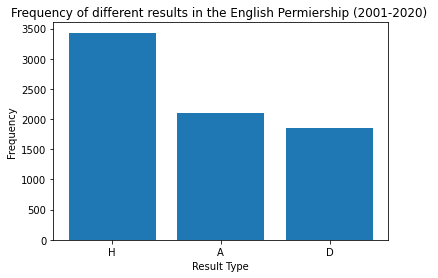

In [59]:
fig, chart = plt.subplots() 
data = my_df['FTR'].value_counts() 

points = data.index 
frequency = data.values 

chart.bar(points, frequency) 

chart.set_title('Frequency of different results in the English Permiership (2001-2020) ') 
chart.set_xlabel('Result Type') 
chart.set_ylabel('Frequency')

We can see home team wins are way more prevalent than away team wins or draws. This makes sense as the crowd plays an important role in soccer. OK, what else can we plot?  

How about what team has played the most home games? 

Text(0, 0.5, 'Frequency')

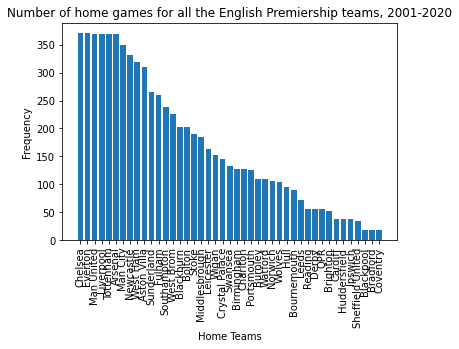

In [56]:
# create a figure and axis 
fig, ax = plt.subplots() 

# count the occurrence of each class 
data = my_df['HomeTeam'].value_counts() 
# get x and y data 
points = data.index 
frequency = data.values 
# create bar chart 
ax.bar(points, frequency) 
plt.setp(ax.get_xticklabels(), rotation=90)
# set title and labels 
ax.set_title('Number of home games for all the English Premiership teams, 2001-2020') 
ax.set_xlabel('Home Teams')
ax.set_ylabel('Frequency')


There are other things we could plot but let's say that's it for now. We can move on to the next step.

Now that the file is in dataframe we assign some columns to x and the label to y. In our case the label is the full time result ("FTR"). Let's make sure we can print a label

In [6]:
print("For row 149 the teams playing are " + str(my_df["HomeTeam"][149]) + " and " + str(my_df["AwayTeam"][149]) + " and the label is "  + str(my_df["FTR"][149]) + " and the day is " + str(my_df["Date"][149]))

For row 149 the teams playing are Arsenal and Southampton and the label is H and the day is 02/12/00



Before assigning the features to X and y we need to convert strings and text to something else since you cannot input strings to a neural network 

What features to use? Well, a theory is we need the teams that are playing and their statistics throughout the match: assists, corners and so on. Date? For now we are going to use just the day ofthe week so we will start with the following features in x:

*   Day of the week when the match was played (i.e Saturday)  
*   HomeTeam
*   AwayTeam
*   HTHG (Half Time Home Goals)
*   HTAG (Half Time Away Goals)
*   HTR  (Half Time Result)
*   HS (Home Team Shots)
*   AS (Away Team Shots)
*  HC (Home Team Corners)
*  AC (Away Team Corners)
*  HF (Home Team Fouls)
*  AF (Away Team Fouls)
*  HY (Homw Team Yellow Cards)
*  AY (Away Team Yellow Cards)
*   HR (Home Team Red Cards)
*   AR (Away Team Red Cards)

Now we need to convert the object columns to numbers. First we create a new dataframe with the object columns. 

We also drop the referee column since we are not going to use it and then we print a few rows

In [7]:
epl_df_objects = my_df.copy()
epl_df_objects.drop('Referee', axis=1, inplace=True)


epl_df_objects.head()



,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,19/08/00,Charlton,Man City,4,0,H,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0
1,19/08/00,Chelsea,West Ham,4,2,H,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0
2,19/08/00,Coventry,Middlesbrough,1,3,A,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0
3,19/08/00,Derby,Southampton,2,2,D,1,2,A,6,13,4,6,5,8,11,13,1,1,0,0
4,19/08/00,Leeds,Everton,2,0,H,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0


Now we are going to check if there are any null values


In [8]:
print(epl_df_objects.isnull().values.sum())


0


Hooray! No null values so we don't have to fix our data. We can move on to the next step: fixing some of the features we want to keep.

Since we only want the day the match was played we convert the date to day of the week in a new column and drop the original date column 

In [9]:
#converting match date to epoch and day of the week

epl_df_objects["matchDate"] = pd.to_datetime(epl_df_objects["Date"], infer_datetime_format=True)
epl_df_objects['matchDay'] = epl_df_objects['matchDate'].dt.day_name()

print(epl_df_objects["matchDate"][0])
print(epl_df_objects['matchDay'][149])

epl_df_objects.drop('Date', axis=1, inplace=True)
epl_df_objects.drop('matchDate', axis=1, inplace=True)


epl_df_objects.head()

2000-08-19 00:00:00
Saturday


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,matchDay
0,Charlton,Man City,4,0,H,2,0,H,17,8,14,4,6,6,13,12,1,2,0,0,Saturday
1,Chelsea,West Ham,4,2,H,1,0,H,17,12,10,5,7,7,19,14,1,2,0,0,Saturday
2,Coventry,Middlesbrough,1,3,A,1,1,D,6,16,3,9,8,4,15,21,5,3,1,0,Saturday
3,Derby,Southampton,2,2,D,1,2,A,6,13,4,6,5,8,11,13,1,1,0,0,Saturday
4,Leeds,Everton,2,0,H,2,0,H,17,12,8,6,6,4,21,20,1,3,0,0,Saturday


Now we convert all the object columns to numbers because a neural network does not accept text

In [10]:
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['HomeTeam'], prefix = ['HomeTeam'])
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['AwayTeam'], prefix = ['AwayTeam'])
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['HTR'], prefix = ['HTR'])
epl_df_objects = pd.get_dummies(epl_df_objects, columns=['matchDay'], prefix = ['matchDay'])

epl_df_objects.head()



,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,HomeTeam_Arsenal,HomeTeam_Aston Villa,HomeTeam_Birmingham,HomeTeam_Blackburn,HomeTeam_Blackpool,HomeTeam_Bolton,HomeTeam_Bournemouth,HomeTeam_Bradford,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Charlton,HomeTeam_Chelsea,HomeTeam_Coventry,HomeTeam_Crystal Palace,HomeTeam_Derby,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Hull,HomeTeam_Ipswich,HomeTeam_Leeds,HomeTeam_Leicester,...,AwayTeam_Coventry,AwayTeam_Crystal Palace,AwayTeam_Derby,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Hull,AwayTeam_Ipswich,AwayTeam_Leeds,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man United,AwayTeam_Middlesbrough,AwayTeam_Newcastle,AwayTeam_Norwich,AwayTeam_Portsmouth,AwayTeam_QPR,AwayTeam_Reading,AwayTeam_Sheffield United,AwayTeam_Southampton,AwayTeam_Stoke,AwayTeam_Sunderland,AwayTeam_Swansea,AwayTeam_Tottenham,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,HTR_A,HTR_D,HTR_H,matchDay_Friday,matchDay_Monday,matchDay_Saturday,matchDay_Sunday,matchDay_Thursday,matchDay_Tuesday,matchDay_Wednesday
0,4,0,H,2,0,17,8,14,4,6,6,13,12,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,4,2,H,1,0,17,12,10,5,7,7,19,14,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,1,3,A,1,1,6,16,3,9,8,4,15,21,5,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,2,2,D,1,2,6,13,4,6,5,8,11,13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,2,0,H,2,0,17,12,8,6,6,4,21,20,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


Before assigning features to X and the label to y we need to convert the label to numeric values. We also assign all the relevant features to an intermediate variable

In [32]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


epl_df_objects['FTR']= label_encoder.fit_transform(epl_df_objects['FTR']) 
  
print('Unique values for our label are: ', epl_df_objects['FTR'].unique())
print('if the home team wins the label is ', epl_df_objects['FTR'][0])
print('if the away team wins the label is ', epl_df_objects['FTR'][2])
print('if there is a tie the label is ', epl_df_objects['FTR'][3])

label = epl_df_objects['FTR']
print('the result for the match in row 149 is ', label[149])

print(epl_df_objects.iloc[:,3:113])

features = epl_df_objects.iloc[:,3:113]

#for col in features.columns: 
#    print(col) 

Unique values for our label are:  [2 0 1]
if the home team wins the label is  2
if the away team wins the label is  0
if there is a tie the label is  1
the result for the match in row 149 is  2
      HTHG  HTAG  HS  ...  matchDay_Thursday  matchDay_Tuesday  matchDay_Wednesday
0        2     0  17  ...                  0                 0                   0
1        1     0  17  ...                  0                 0                   0
2        1     1   6  ...                  0                 0                   0
3        1     2   6  ...                  0                 0                   0
4        2     0  17  ...                  0                 0                   0
...    ...   ...  ..  ...                ...               ...                 ...
7381     0     0  11  ...                  0                 0                   0
7382     1     0  21  ...                  0                 0                   0
7383     2     0  17  ...                  0               

Now we can create X and y and divide the dataset in a training set and a test set. We will use the test set to check and see if we are overfitting

In [12]:
from sklearn.model_selection import train_test_split

y=np.ravel(label)
X = features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

print("The shape of X_train is " + str(X_train.shape))
print("The size of y_train is " + str(y_train.shape))
print("The size of X_test set is " + str(X_test.shape))
print("The size of y_test is " + str(y_test.shape))

The shape of X_train is (4948, 110)
The size of y_train is (4948,)
The size of X_test set is (2438, 110)
The size of y_test is (2438,)


Great!

Let's print a few rows of y_train to make sure they are one hot-encoded

In [13]:
#one hot-encoding y_train and y_test
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

print("The size of y_train is " + str(y_train.shape))
print("The size of y_test is " + str(y_test.shape))

print(y_train[0])

The size of y_train is (4948, 3)
The size of y_test is (2438, 3)
[0. 0. 1.]


We now create our models. We will start with a neural network using tensorflow and keras

In [35]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(330, input_dim=110, activation='relu'), 
      tf.keras.layers.Dense(10, input_dim=330, activation='relu'),                               
      tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 330)               36630     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                3310      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 33        
Total params: 39,973
Trainable params: 39,973
Non-trainable params: 0
_________________________________________________________________


Our model is now ready to be fitted. 

In [15]:
history = model.fit(X_train, y_train, epochs=65)


Epoch 1/65
155/155 [==============================] - 0s 1ms/step - loss: 0.9039 - accuracy: 0.5887
Epoch 2/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7941 - accuracy: 0.6407
Epoch 3/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7605 - accuracy: 0.6496
Epoch 4/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7641 - accuracy: 0.6500
Epoch 5/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7489 - accuracy: 0.6538
Epoch 6/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7467 - accuracy: 0.6643
Epoch 7/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7542 - accuracy: 0.6591
Epoch 8/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7270 - accuracy: 0.6686
Epoch 9/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7176 - accuracy: 0.6718
Epoch 10/65
155/155 [==============================] - 0s 1ms/step - loss: 0.7163 - accuracy: 0.6760

Before evaluating our model let's plot our loss and accuracy to see how they changed while the model was trained


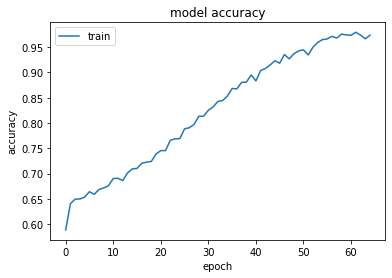

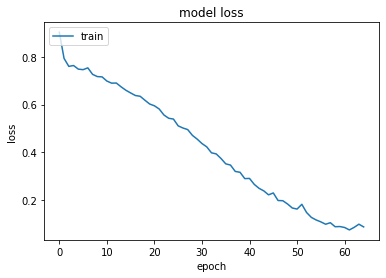

In [16]:
#accuracy history
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#loss history
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


Now we can evaluate our model on the test set

In [17]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

77/77 [==============================] - 0s 944us/step - loss: 3.2080 - accuracy: 0.5710
Test Score: 3.2079906463623047
Test Accuracy: 0.5709598064422607


Now let's try to make a prediction with data from a future premiership match from this current season:

Arsenal at home vs Norwich on Wednesday 07/01/2020



In [18]:
Xnew = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
print('the shape of our input data is ', Xnew.shape)

 # make a prediction
ynew = np.argmax(model.predict(Xnew), axis=-1)
# show the inputs and predicted outputs
print("X = %s " % Xnew)
print("Prediction = %s" % ynew[0])

if ynew[0] == 2:
  print("Home team is going to win")
elif ynew[0] == 0:
  print("Away team is going to win")
else:
  print("It is going to be a draw")

the shape of our input data is  (1, 110)
X = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1]] 
Prediction = 2
Home team is going to win


Now let's try to serve the model as an api so people can call it and get predictions for the games they want to know about.

We will use tensorflow serving to create our api

First we save our model


In [19]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 96
drwxr-xr-x 2 root root  4096 Jul  5 04:44 assets
-rw-r--r-- 1 root root 89355 Jul  5 04:44 saved_model.pb
drwxr-xr-x 2 root root  4096 Jul  5 04:44 variables


Now we download the tensorflow model server code 

In [20]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  11190      0 --:--:-- --:--:-- --:--:-- 11232
OK
Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Ign:9 https://developer.d

Now we install tensorflow model server

In [21]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 187 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.2.0 [187 MB]
Fetched 187 MB in 4s (52.4 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.2.0_all.deb ...
Unpacking tensorflow-model-server (2.2.0) ...
Setting up tensorflow-model-server (2.2.0) ...


Now we can run our api server. 

In [22]:
os.environ["MODEL_DIR"] = MODEL_DIR


In [23]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=epl_predictions \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


Now we can create the a json object to send as request to the api. We are going to send all the remaining Arsenal games and see what are the predictions so we can finally figure out if Arsenal is going to reach the Champions League

In [24]:
entry = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1], 
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0], 
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
                ])
                  
print(type(entry))
print(entry.shape)

the_list = entry.tolist()
print(type(the_list))


data = json.dumps({"signature_name": "serving_default", "instances": the_list})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

<class 'numpy.ndarray'>
(8, 110)
<class 'list'>
Data: {"signature_name": "serving_default", "instances": ... 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]}


Now that we have our object we can send it to the api and we can receive the prediction from our model

Since we sent 8 games we should receive back an array of 8 x 3 shape. We print the shape to be sure. We then
We then print the index of the highest probability to see what are our results

In [31]:
!pip install -q requests


headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/epl_predictions:predict', data=data, headers=headers)

response = json.loads(json_response.text)
predictions = response['predictions']

print(json_response)
print(json_response.text)
print(response['predictions'])

my_predictions = np.array(predictions)
print("The predictions are: ",np.argmax(my_predictions,axis=1))


<Response [200]>
{
    "predictions": [[2.67973306e-14, 0.000472112908, 0.999527931], [0.0562632605, 0.000124885497, 0.943611801], [4.96751806e-11, 2.29888587e-06, 0.999997735], [0.00811510161, 0.000195591012, 0.991689324], [1.45687515e-08, 9.3231921e-07, 0.999999046], [8.91271258e-12, 3.68018505e-08, 1.0], [0.0604688786, 0.000126233645, 0.939404905], [2.11211682e-06, 2.21750751e-09, 0.999997854]
    ]
}
[[2.67973306e-14, 0.000472112908, 0.999527931], [0.0562632605, 0.000124885497, 0.943611801], [4.96751806e-11, 2.29888587e-06, 0.999997735], [0.00811510161, 0.000195591012, 0.991689324], [1.45687515e-08, 9.3231921e-07, 0.999999046], [8.91271258e-12, 3.68018505e-08, 1.0], [0.0604688786, 0.000126233645, 0.939404905], [2.11211682e-06, 2.21750751e-09, 0.999997854]]
The predictions are:  [2 2 2 2 2 2 2 2]


OK, we got all our results back. The model says that for the 8 games we sent the home team is going to win all of them.

Do we believe it? Kinda, usually, a home team has the advantage of the crowd but during in this Covid-19 era there is no crowd anymore. Our model doesn't know that though so that's a good feature to add for a future iteration of the model.

For now let's assume we believe it. If this is the case then we have the following record for Arsenal:

5 wins (it is playing as the home team in 5 of the games we sent) and 3 losses (it is playing as the away team in the other 3 games we sent)

Before playing Norwich (the first of the 8 games we sent to our api) Arsenal had 43 points. 43 + 15 (5 games won as the home team) = 58 so, according to our model, the Gunners will end the season with 58 points.
